# Обучение Vit (visinon transformer)

In [ ]:
%pip install transformers -q

## Подготовка данных

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import glob
import random
from collections import defaultdict
import time
from IPython.display import clear_output
import os

from sklearn.model_selection import train_test_split

random.seed(10)
torch.cuda.manual_seed(10)
np.random.seed(10)

os.mkdir('/kaggle/working/dataset')
os.mkdir('/kaggle/working/dataset/train')

from distutils.dir_util import copy_tree

copy_tree("/kaggle/input/crop-dataset-parnocopit/class_0/class_0", "/kaggle/working/dataset/train/class_0")
copy_tree("/kaggle/input/crop-dataset-parnocopit/class_1/class_1", "/kaggle/working/dataset/train/class_1")
copy_tree("/kaggle/input/crop-dataset-parnocopit/class_2/class_2", "/kaggle/working/dataset/train/class_2")

def is_valid_file(path):
    # Получаем только имя файла из полного пути
    filename = os.path.basename(path)
    
    # Проверяем, что это файл изображения (не директория) и его имя присутствует в списке train_files_path
    return filename.endswith('.jpg') and any(filename in os.path.basename(p) for p in train_files_path)

data_dir = "/home/jupyter/datasphere/project/dataset_crop/train"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2].split('_')[1] for path in data_image_paths]

print(f'Изображений для обучения и валидации: {len(data_image_paths)}')
print(f'Классов для обучения и валидации: {len(set(data_image_labels))}')

train_files_path, val_files_path = train_test_split(
    data_image_paths,
    test_size = 0.3,
    stratify = data_image_labels)

print(f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}")

transforms_train = torchvision.transforms.Compose([
    transforms.Resize(224), # все изображения и так 224х224, но на всякий случай
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

transforms_validation = torchvision.transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])


Изображений для обучения и валидации: 15965
Классов для обучения и валидации: 3
Изображений в train: 11175
Изображений в val: 4790


FileNotFoundError: Found no valid file for the classes .ipynb_checkpoints. 

Количество классов в train:  3
Количество классов в val:  3
Количество классов одинаково:  True


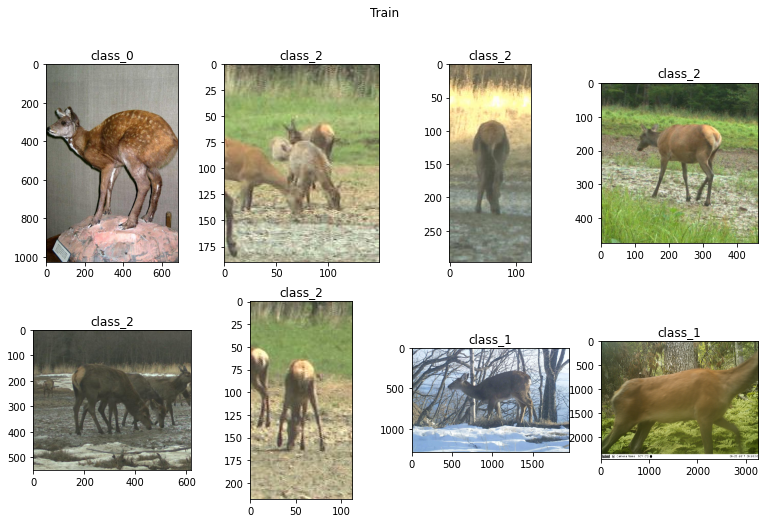

In [19]:

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transforms_train,
    is_valid_file = lambda x: x in train_files_path)

validation_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transforms_validation,
    is_valid_file = lambda x: x in val_files_path)

print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(validation_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(validation_dataset.classes))

def Show_Sample(path, suptitle):
    n = random.randint(0, len(path) - 9)
    fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (13, 8))
    fig.suptitle(suptitle)
    for i in range(8):
        axs[i // 4, i % 4].set_title(path[n + i].split('/')[-2])
        axs[i // 4, i % 4].imshow(plt.imread(path[n + i]))

Show_Sample(train_files_path, 'Train')


## Обучение

In [20]:
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True)

val_dataloader = torch.utils.data.DataLoader(
    validation_dataset, batch_size = batch_size, shuffle = False)

from transformers import ViTForImageClassification

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = ViTForImageClassification.from_pretrained('WinKawaks/vit-small-patch16-224')

for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Linear(model.classifier.in_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

from sklearn.metrics import f1_score, accuracy_score

def train(model, vit, train_loader, val_loader, criterion, optimizer, scheduler, epochs = 20):
    
    try:

        for epoch in range(epochs):

            vit.train()
            loss_train, loss_val = 0, 0
            f1_train, f1_val = 0, 0
            acc_train, acc_val = 0, 0

            for x_batch, y_batch in train_loader:

                optimizer.zero_grad()
                x_batch = x_batch.to(device)
                y_batch = y_batch.long().to(device)
                logits = vit(x_batch).logits
                loss = criterion(logits, y_batch)
                loss_train += loss
                f1 = f1_score(y_batch.cpu(), logits.argmax(dim = 1).cpu(), average = 'weighted')
                acc = accuracy_score(y_batch.cpu(), logits.argmax(dim = 1).cpu())
                f1_train += f1
                acc_train += acc
                print(round(f1, 4), round(acc, 4))

                loss.backward()
                optimizer.step()

            print('ВАЛИДАЦИЯ')
            vit.eval()
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.long().to(device)
                with torch.no_grad():
                    logits = vit(x_batch).logits
                    loss = criterion(logits, y_batch)
                    loss_val += loss
                    f1 = f1_score(y_batch.cpu(), logits.argmax(dim = 1).cpu(), average = 'weighted')
                    acc = accuracy_score(y_batch.cpu(), logits.argmax(dim = 1).cpu())
                    f1_val += f1
                    acc_val += acc
                    print(round(f1, 4), round(acc, 4))

            print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {loss_train / len(train_loader)}, Val Loss: {loss_val / len(val_loader)}, F1 train: {f1_train / len(train_loader)}, F1 val: {f1_val / len(val_loader)}')
            
    except KeyboardInterrupt: 0

train(None, model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epochs = 20)


0.8864 0.8906
0.892 0.8906
0.8575 0.8594
0.8448 0.8438
0.8737 0.875
0.8644 0.8672
0.9051 0.9062
0.9202 0.9219
0.9061 0.9062
0.8547 0.8594
0.8818 0.8828
0.8161 0.8203
0.9009 0.9062
0.879 0.8828
0.8497 0.8516
0.8549 0.8594
0.8593 0.8594
0.867 0.8672
0.885 0.8906
0.8006 0.8047
0.8721 0.875
0.847 0.8516
0.8999 0.8984
0.8908 0.8906
0.8463 0.8516
0.8864 0.8906
0.8472 0.8516
0.9381 0.9375
0.8861 0.8906
0.8517 0.8516
0.8667 0.8672
0.8274 0.8281
0.9125 0.9141
0.8733 0.875
0.8879 0.8906
0.8786 0.8828
0.9024 0.9062
0.8541 0.8594
0.8495 0.8516
0.9188 0.9219
0.8868 0.8906
0.9288 0.9297
0.9277 0.9297
0.8205 0.8203
0.8077 0.8125
0.8888 0.8906
0.8963 0.8984
0.8416 0.8438
0.8624 0.8672
0.8221 0.8203
0.8093 0.8125
0.881 0.8828
0.8504 0.8516
0.9076 0.9062
0.8343 0.8359
0.8897 0.8906
0.8863 0.8906
0.8568 0.8594
0.8471 0.8516
0.8304 0.8359
0.8125 0.8203
0.8656 0.8672
0.845 0.8516
0.8291 0.8359
0.8872 0.8906
0.8824 0.8828
0.872 0.8672
0.8578 0.8594
0.8735 0.875
0.8572 0.8594
0.8505 0.8516
0.8361 0.8438
0.89

## Оценка Модели

In [21]:
results_train = torch.Tensor([])
real_train = torch.Tensor([])

with torch.no_grad():
    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.long().to(device)
        logits = model(x_batch).logits
        cls = logits.argmax(dim = 1).cpu()
        results_train = torch.cat((results_train, cls))
        real_train = torch.cat((real_train, y_batch.cpu()))

results_val = torch.Tensor([])
real_val = torch.Tensor([])

with torch.no_grad():
    for x_batch, y_batch in val_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.long().to(device)
        logits = model(x_batch).logits
        cls = logits.argmax(dim = 1).cpu()
        results_val = torch.cat((results_val, cls))
        real_val = torch.cat((real_val, y_batch.cpu()))


In [22]:
from sklearn.metrics import classification_report

print(classification_report(real_val, results_val))

              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74       986
         1.0       0.82      0.74      0.78      1173
         2.0       0.89      0.95      0.92      2631

    accuracy                           0.85      4790
   macro avg       0.82      0.80      0.81      4790
weighted avg       0.85      0.85      0.85      4790



## Сохранение модели

In [23]:
import torch

output_file = './vit_small_model_best.pth'
torch.save(model, output_file)
